In [15]:
import numpy as np
import pandas as pd
from pathlib import Path
import plotly.express as px
import plotly.subplots as ps
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import json

In [16]:
def agg1(params, param_of_interest):
    params = params.sort_index()
    params["config"] = ["Vanilla", "Bayes prior", "Binary Prior"]
    param_of_interest = "config"
    return params, param_of_interest
def agg2(params, param_of_interest):
    params = params.sort_index()
    return params, param_of_interest
def agg3(params, param_of_interest):
    params = params.sort_index()
    params["Config"] = ["Vanilla\n5 TFs", "Masking\n5 TFs", "Vanilla\n10 TFs", "Masking\n10 TFs"]
    params = params.iloc[[0,2,1,3]]
    param_of_interest = "Config"
    return params, param_of_interest
def agg4(params, param_of_interest):
    params = params.sort_values(param_of_interest)
    params["Config"] = ["Vanilla\n400", "Masking\n400", "Masking\n200", "Masking\n100", "Vanilla\n200", "Vanilla\n100"]
    param_of_interest = "Config"
    params = params.sort_values("Config")
    return params, param_of_interest
def agg5(params, param_of_interest):
    params = params.sort_values(param_of_interest)
    if len(params)>4:
        params["pert. factor"] = (1/10**np.arange(4, -1,-1)).astype(str)
    else:
        params["pert. factor"] = 1/np.arange(4, 0,-1)

    param_of_interest = "pert. factor"
    params=params.sort_values(param_of_interest)
    return params, param_of_interest
def agg6(params, param_of_interest):
    params[param_of_interest] = params[param_of_interest].astype(float)
    params = params.sort_values(param_of_interest)
    return params, param_of_interest
def agg7(params, param_of_interest):
    params = params.sort_index()
    params["config"] = ["Vanilla_old","Vanilla", "Bayes prior", "Binary Prior"]
    param_of_interest = "config"
    return params, param_of_interest
functions = {
    "agg1":agg1,
    "agg2":agg2,
    "agg3":agg3,
    "agg4":agg4,
    "agg5":agg5,
    "agg6":agg6,
    "agg7":agg7,
             }

In [17]:
save = False

In [18]:
# get environment
with open("./data/experiment_configs.json", "r") as rf:
    config_sets = json.load(rf)

experiment = "paper"
config_set = config_sets[experiment]
include = config_set["include"]
id_len = config_set["id_len"]
prefix = config_set["prefix"]
param_of_interest = config_set["param_of_interest"]
agg = config_set["function"]

include = np.array([98,99])
id_len = 3
prefix = "run_"
experiment = None
param_of_interest = "data_source"
agg = None


In [19]:
metrics = dict()
models_path = Path("/data/toulouse/bicycle/notebooks/experiments/masking/data/model_runs/models/")
#include = np.arange(31,34)
#prefix = "test_run_"
#id_len = 5
#experiment = "maskloss"
#param_of_interest = "masking_mode"
# 1 is trad_loading
for path in models_path.iterdir():
     try:
         if int(path.name[-id_len:]) not in include:
               continue
     except ValueError:
          continue
     if path.name[:-id_len] != prefix:
          continue
     logs_path = path / "mylogger/logger.parquet"

     if not logs_path.exists():
         continue
     df = pd.read_parquet(logs_path)
     if "train_mask_loss" in df.columns:
         df["train_mask"]=df["train_mask_loss"]
         df = df.drop(columns="train_mask_loss")
     else:
          df["train_mask"] = np.nan
     df["train_spectral"]=df["train_spectral_loss"]
     df = df.drop(columns="train_spectral_loss")
     df = df.set_index("epoch", drop=True)
     print(len(df["train_loss"]))
     #if len(df["train_loss"]) >5000:
     #     raise NotImplementedError("More than 4999 epochs")
     metrics[str(path.name)] = df
sorted_keys = sorted([key for key in metrics.keys()])

10000
5309


In [20]:
# get environment
plot_path = Path("/data/toulouse/bicycle/notebooks/experiments/masking/data/model_runs/plots")
columns = [
     "model_lr",
     "model_n_genes",
     "model_n_samples",
     "model_gt_interv",
    "pretraining_time",
    "training_time",
    "compile",
    "trad_loading",
    "scale_mask",
    "grn_noise_p",
    "n_epochs",
    "use_hard_mask",
    "masking_mode",
    "bin_prior",
    "data_id"
    ]
if not param_of_interest in columns:
    columns.append(param_of_interest)
    print(f"Adding {param_of_interest}")
params = pd.DataFrame(columns=columns)
for dir in plot_path.iterdir():
    if dir.name[:-id_len] != prefix:
         continue
    if int(dir.name[-id_len:]) not in include:
          continue
    print(dir.name)
    if (dir/ "manual_globals.csv").exists():
        params.loc[dir.name] = np.nan
        p = pd.read_csv(dir/"manual_globals.csv", index_col=0)
        available_paras=[n for n in params.columns if n in p.columns]
        params.loc[dir.name, available_paras] = p.loc[dir.name,available_paras]
        continue
    try:
        globs = pd.read_csv(dir/ "globals.csv", delimiter=",").set_index("0", drop=True).T
        available_paras = [n for n in columns if n in globs.columns]
        params.loc[dir.name] = globs[available_paras].iloc[1]
    except FileNotFoundError:
        print(f"globals file for {dir.name} not found!")
        params.loc[dir.name] = np.nan
if experiment == "scalemask":
     params = pd.read_csv(models_path.parent/"param1.csv", index_col=0).sort_values("scale_mask")
    
if agg != None:
     params, param_of_interest = functions[agg](params, param_of_interest)
#params = pd.read_csv(plot_path.parent/"param1.csv", index_col=0)

Adding data_source
run_098
run_099


In [21]:
params

,model_lr,model_n_genes,model_n_samples,model_gt_interv,pretraining_time,training_time,compile,trad_loading,scale_mask,grn_noise_p,n_epochs,use_hard_mask,masking_mode,bin_prior,data_id,data_source
run_098,0.001,10,8000,"tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0...",NaN,1964.0966160297394,True,True,1,NaN,10000,False,NaN,False,NaN,create_data_scMultiSim
run_099,0.001,10,8000,"tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0...",NaN,990.6633965969086,True,True,1,NaN,10000,False,NaN,False,NaN,create_data


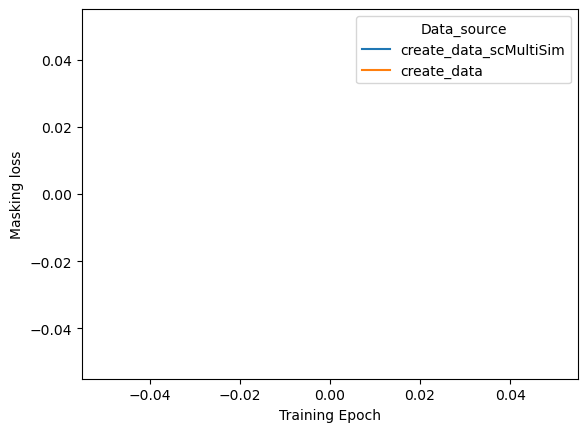

In [22]:

for key in params.index:
    plt.plot(metrics[key].index,
             #np.log(
                 metrics[key]["train_mask"],
                 #),
             label= params.loc[key,param_of_interest])
plt.legend(title=param_of_interest.capitalize())
plt.ylabel("Masking loss")
plt.xlabel("Training Epoch")
if save:
    print("Saving!")
    plt.savefig(f"./presentation/{experiment}_{param_of_interest}_trainmasklines.pdf")

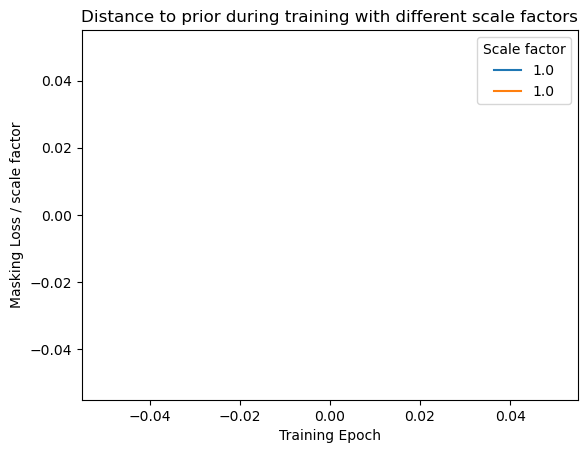

In [23]:
for key in params.index:
    scale_factor = float(params.loc[key,"scale_mask"])
    x=metrics[key].index
    y=metrics[key]["train_mask"]
    plt.plot(x,
             #np.log(
                 y/scale_factor,
                 #),
             label= scale_factor)
plt.legend(title="Scale factor")
plt.ylabel("Masking Loss / scale factor")
plt.xlabel("Training Epoch")
plt.title("Distance to prior during training with different scale factors")
if save:
    print("Saving!")
    plt.savefig(f"./presentation/{experiment}_{param_of_interest}_priordistance.pdf")


/tmp/ipykernel_3056329/3951229379.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[n, c].legend(loc="upper right")


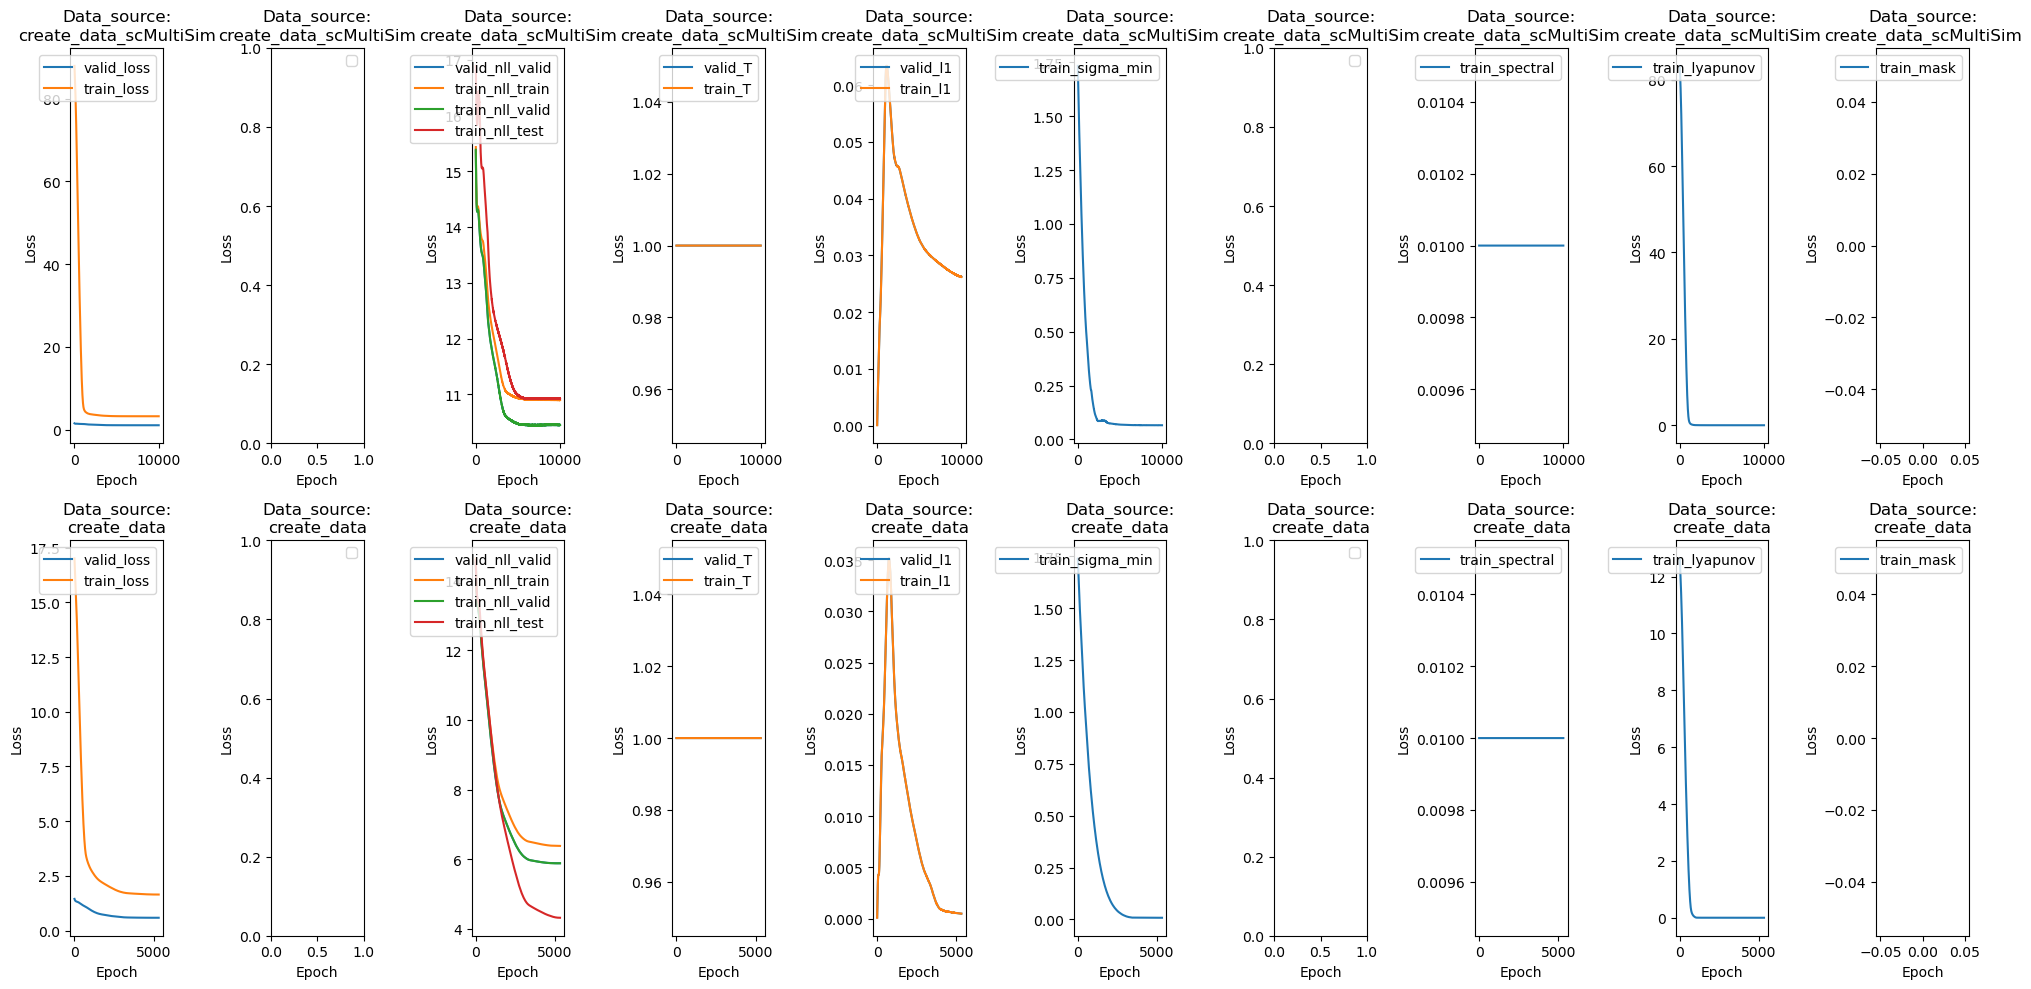

In [ ]:
# plot loss vs validation loss
components = ["loss", "kl", "nll", "T", "l1","sigma", "alpha", "spectral", "lyapunov", "mask"]
fig, ax = plt.subplots(nrows=len(metrics.keys()), ncols=len(components), figsize= (40, 20))
for n, key in enumerate(params.index):
    for c, comp in enumerate(components):
        for x in df.columns:
            if comp in x:
                ax[n, c].plot(
                    metrics[key].index,
                    metrics[key][x],
                    label=x
                )
        #train= comp.replace(".", "train")
        #valid = comp.replace(".", "valid")
        #ax[n, c].plot(
        #    df.index,
        #    df[train],
        #    label=train
        #)
        #ax[n, c].plot(
        #    df.index,
        #    df[valid],
        #    label=valid
        #)
        ax[n, c].legend(loc="upper right")
        ax[n, c].set_ylabel("Loss")
        ax[n, c].set_xlabel("Epoch")
        ax[n, c].set_title(f"{param_of_interest.capitalize()}: {str(params.loc[key, param_of_interest])}")
        #ax[n, c].set_title(params.loc[key,"data_id"])
fig.align_xlabels()
fig.set_tight_layout("tight")
fig.show()
if save:
    print("Saving!")
    fig.savefig(f"./presentation/{experiment}_{param_of_interest}_loss_tableau.pdf")

metrics = dict()
models_path = Path("/data/toulouse/bicycle/notebooks/experiments/masking/data/model_runs/models/")
pretraining = True
# 1 is trad_loading
for path in models_path.iterdir():
    logs_path = path / "lightning_logs"
    
    if pretraining:
        logs_path/= "version_0"
    else:
        logs_path/="version_1"
    if not logs_path.exists():
        continue
    df = pd.read_csv(logs_path/"metrics.csv")
    df = df.drop(columns=["step"])
    df = df.groupby("epoch").agg(lambda x: x.dropna())
    metrics[str(path.name)] = df

fig, ax = plt.subplots(nrows=df.shape[1]//2, ncols=2, figsize = (25, 20))
for (key, df), color in zip(metrics.items(), mc.BASE_COLORS.keys()):
    
    for n,col in enumerate(df.columns):
        if n==df.shape[1]//2:
            break
        ax[n, 0].plot(df.index,
                   df[col],
                   label= key,
                   color=color)
        if "valid"+col[5:] in df.columns:
            ax[n, 1].plot(df.index,
                       df["valid"+col[5:]],
                       label= key,
                       color=color)
        ax[n, 0].set_title(col)
        ax[n, 1].set_title("valid"+col[5:])
    
h, l=ax[0,0].get_legend_handles_labels()
fig.legend(h,l)
fig.tight_layout()
fig.show()